# Logistic Regression - Baseline Model
## Setup

In [ ]:
# !pip install gensim

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
%cd ..

D:\OneDrive\w210\capstone-project


In [69]:
import pandas as pd
import numpy as np
# import pickle
# import json
import gensim

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Data Processing - Train - Val - Test preparation

In [39]:
# Import Drug2Vec Embedding - Morgan Fingerprints, Cosine Similarity
drug2vec_model = gensim.models.KeyedVectors.load_word2vec_format(fname="weights/drug2vec_300clusters_morgan_cosine.txt", binary=False)
print('Number of drugs available:', len(drug2vec_model.index_to_key))
print('Example - top 10 keys:', drug2vec_model.index_to_key[:10])
print('Embedding dimension:', len(drug2vec_model[drug2vec_model.index_to_key[0]]))

# Import Train Set - 3000 balanced
train_df = pd.read_csv('data/ddi_train_balanced_3000.csv', delimiter='\t')
print('Train data dimension:', train_df.shape)

# # Import Validation & Test set
val_df = pd.read_csv('data/ddi_val_api.csv', delimiter='\t')
print('Validation data dimension:', val_df.shape)
test_df = pd.read_csv('data/ddi_test_api.csv', delimiter='\t')
print('Test data dimension:', test_df.shape)

Number of drugs available: 2563
Example - top 10 keys: ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']
Embedding dimension: 300
Train data dimension: (261000, 9)
Validation data dimension: (202633, 9)
Test data dimension: (214302, 9)


In [40]:
list(drug2vec_model['DB00006'][:5])
# drug2vec_model.get_vecattr('DB00006')

[0.2786932, 0.340173, 0.2463323, 0.2927537, 0.2370063]

In [41]:
# Extract Embedding for Drug1 and Drug2
def get_X_y_embedding_data(df, drug2vec_model=drug2vec_model, method='Concatenate'):
    """From Drug1 & Drug2 ids, import the precalculated embeddings,
    Convert to ready data for training
    """
    # df_embedding = df.copy()

    # Remove the 4 SMILES causing error, only include SMILES in drug2vec.txt
    valid_smiles = drug2vec_model.index_to_key
    df = df[df['d1'].isin(valid_smiles) & df['d2'].isin(valid_smiles)]

    # Extract embedding
    df['d1_embedding'] = df['d1'].apply(lambda x: drug2vec_model[x])
    df['d2_embedding'] = df['d2'].apply(lambda x: drug2vec_model[x])

    # Drop all records that could not extract embedding (SMILES errors)
    df = df.dropna(subset=['d1_embedding', 'd2_embedding'], how='any')
    df = df[["d1_embedding", "d2_embedding", "interaction_type", "severity"]]

    # Extract Drug1 embedding, reshape
    # d1_embed = np.stack(df['d1_embedding'].values)
    d1_embed = np.array(df['d1_embedding'].tolist())
    print('Drug1 Embedding Dimension:',d1_embed.shape)

    # d2_embed = np.stack(df['d2_embedding'].values)
    d2_embed = np.array(df['d2_embedding'].tolist())
    print('Drug2 Embedding Dimension:',d2_embed.shape)

    # Concatnate drug 1 & drug 2 embeddings
    if method == 'Difference':
        X = d1_embed - d2_embed
        print('Feature Dimension:', X.shape)

    else:
        X = np.hstack((d1_embed, d2_embed))
        print('Drug 1 Concatenate with Drug 2 Embedding Dimension:', X.shape)

    y = df['interaction_type'].values
    print('Interaction Type Label Dimension:', y.shape)

    y_severity = df['severity'].values
    y_severity = (y_severity == "high").astype('int')
    print('Interaction Severity Label Dimension:', y.shape)

    return X, y, y_severity

In [42]:
# Val Set
print("### Val Data Processing:")
X_val, y_val, y_severity_val = get_X_y_embedding_data(val_df, drug2vec_model, method='Concatenate')

# Save ready X, y, y_severity to pickle
# with open("data/Xy_val_morgan_tanimoto_300basis.pkl", "wb") as f:
#     pickle.dump({"X_val": X_val, "y_val": y_val, "y_severity_val": y_severity_val}, f)

### Val Data Processing:
Drug1 Embedding Dimension: (202373, 300)
Drug2 Embedding Dimension: (202373, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (202373, 600)
Interaction Type Label Dimension: (202373,)
Interaction Severity Label Dimension: (202373,)


In [43]:
# Test Set
print("### Test Data Processing:")
X_test, y_test, y_severity_test = get_X_y_embedding_data(test_df, drug2vec_model, method='Concatenate')

# Save ready X, y, y_severity to pickle
# with open("data/Xy_test_morgan_tanimoto_300basis.pkl", "wb") as f:
#     pickle.dump({"X_test": X_test, "y_test": y_test, "y_severity_test": y_severity_test}, f)

### Test Data Processing:
Drug1 Embedding Dimension: (214015, 300)
Drug2 Embedding Dimension: (214015, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (214015, 600)
Interaction Type Label Dimension: (214015,)
Interaction Severity Label Dimension: (214015,)


In [44]:
# Train Set
print("### Train Data Processing:")
X_train, y_train, y_severity_train = get_X_y_embedding_data(train_df, drug2vec_model, method='Concatenate')

# Save ready X, y, y_severity to pickle
# with open("data/Xy_train_morgan_tanimoto_300basis.pkl", "wb") as f:
#     pickle.dump({"X_train": X_train, "y_train": y_train, "y_severity_train": y_severity_train}, f)

### Train Data Processing:
Drug1 Embedding Dimension: (260329, 300)
Drug2 Embedding Dimension: (260329, 300)
Drug 1 Concatenate with Drug 2 Embedding Dimension: (260329, 600)
Interaction Type Label Dimension: (260329,)
Interaction Severity Label Dimension: (260329,)


## Training

In [29]:
# # Import Train Data
# with open("data/Xy_train_morgan_tanimoto_300basis.pkl", "rb") as f:
#     train_data = pickle.load(f)
#     X_train = train_data["X_train"]
#     y_train = train_data["y_train"]
#     y_severity_train = train_data["y_severity_train"]
#
# with open("data/Xy_val_morgan_tanimoto_300basis.pkl", "rb") as f:
#     val_data = pickle.load(f)
#     X_val = val_data["X_val"]
#     y_val = val_data["y_val"]
#     y_severity_val = val_data["y_severity_val"]
#
# with open("data/Xy_test_morgan_tanimoto_300basis.pkl", "rb") as f:
#     test_data = pickle.load(f)
#     X_test = test_data["X_test"]
#     y_test = test_data["y_test"]
#     y_severity_test = test_data["y_severity_test"]
#
# print('Train Data Feature Dimension:', X_train.shape)
# print('Train Interaction Type Label Dimension:', y_train.shape)
# print('Validation Data Feature Dimension:', X_val.shape)
# print('Validation Interaction Type Label Dimension:', y_val.shape)
# print('Test Data Feature Dimension:', X_test.shape)
# print('Test Interaction Type Label Dimension:', y_test.shape)

In [45]:
print('Train Data Dimension:', X_train.shape)
print('Train Label Dimension:', y_train.shape)
print('Validation Data Dimension:', X_val.shape)
print('Validation Label Dimension:', y_val.shape)
print('Test Data Dimension:', X_test.shape)
print('Test Label Dimension:', y_test.shape)

Train Data Dimension: (260329, 600)
Train Label Dimension: (260329,)
Validation Data Dimension: (202373, 600)
Validation Label Dimension: (202373,)
Test Data Dimension: (214015, 600)
Test Label Dimension: (214015,)


In [11]:
train_df.head(5)

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
0,DB00460,DB08913,Verteporfin,Radium Ra 223 dichloride,Unknown,0,unknown,COC(=O)CCC1=C2NC(\C=C3/N=C(/C=C4\N\C(=C/C5=N/C(=C\2)/C(CCC(O)=O)=C5C)C(C=C)=C4C)C2=CC=C([C@@H](C(=O)OC)[C@@]32C)C(=O)OC)=C1C,[Cl-].[Cl-].[223Ra++]
1,DB08893,DB13345,Mirabegron,Dihydroergocristine,#Drug2 may increase the hypertensive and vasoconstricting activities of #Drug1.,80,unknown,NC1=NC(CC(=O)NC2=CC=C(CCNC[C@H](O)C3=CC=CC=C3)C=C2)=CS1,[H][C@@]12CCCN1C(=O)[C@H](CC1=CC=CC=C1)N1C(=O)[C@](NC(=O)[C@H]3CN(C)[C@]4([H])CC5=CNC6=CC=CC(=C56)[C@@]4([H])C3)(O[C@@]21O)C(C)C
2,DB09095,DB00565,Difluocortolone,Cisatracurium,The risk or severity of myopathy and weakness can be increased when #Drug1 is combined with #Drug2.,63,high,[H][C@@]12C[C@@H](C)[C@H](C(=O)CO)[C@@]1(C)C[C@H](O)[C@@]1(F)[C@@]2([H])C[C@H](F)C2=CC(=O)C=C[C@]12C,COC1=CC2=C(C=C1OC)[C@@H](CC1=CC(OC)=C(OC)C=C1)[N@@+](C)(CCC(=O)OCCCCCOC(=O)CC[N@@+]1(C)CCC3=C(C=C(OC)C(OC)=C3)[C@H]1CC1=CC(OC)=C(OC)C=C1)CC2
3,DB00839,DB01104,Tolazamide,Sertraline,The risk or severity of hypoglycemia can be increased when #Drug1 is combined with #Drug2.,58,high,CC1=CC=C(C=C1)S(=O)(=O)NC(=O)NN1CCCCCC1,CN[C@H]1CC[C@@H](C2=CC(Cl)=C(Cl)C=C2)C2=CC=CC=C12
4,DB04821,DB00751,Nomifensine,Epinastine,The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.,6,high,CN1CC(C2=CC=CC=C2)C2=C(C1)C(N)=CC=C2,NC1=NCC2N1C1=CC=CC=C1CC1=CC=CC=C21


In [46]:
X_train[:5, :5]

array([[0.3202563, 0.2047597, 0.1698416, 0.1682069, 0.1815683],
       [0.2970443, 0.2302046, 0.093352 , 0.1820178, 0.2993925],
       [0.1961161, 0.2051823, 0.2080126, 0.2060105, 0.1482499],
       [0.1846372, 0.4006547, 0.2611165, 0.3555795, 0.2326211],
       [0.0615457, 0.3148001, 0.2030906, 0.2586033, 0.2791453]],
      dtype=float32)

In [13]:
list(y_train[:5])

[0, 80, 63, 58, 6]

In [14]:
list(y_severity_train[:5])

[0, 0, 1, 1, 1]

### Simple Logistic Regression, No Fine-tune

In [60]:
def model_evaluation(y_true, y_pred, prefix="Training"):
    f1_macro = metrics.f1_score(y_true, y_pred, average="macro")
    print(f"{prefix} Marco F1-score: {round(f1_macro,4)}")

    f2_macro =  metrics.fbeta_score(y_true, y_pred, average="macro", beta=2)
    print(f"{prefix} Marco F2-score: {round(f2_macro,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="macro")
    print(f"{prefix} Marco Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="macro")
    print(f"{prefix} Marco Precision: {round(precision_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Marco Accuracy: {round(accuracy_macro,4)}")


In [48]:
# Training Logistic Regression with sklearn
lr = LogisticRegression(penalty='l2', C=0.5, solver="sag", multi_class="ovr", max_iter=100, verbose=1, n_jobs=-1)
print("Training Logistic Regression...")
# Fitting the model to our training vectors
lr.fit(X_train, y_train)
print("Training complete")

Training Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 2916 seconds
Training complete


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 48.6min finished


In [64]:
# Predicting
print("Model Evaluation:")
y_train_pred = lr.predict(X_train)
y_train_pred_prob = lr.predict_proba(X_train)

y_val_pred = lr.predict(X_val)
y_val_pred_prob = lr.predict_proba(X_val)

# y_test_pred = lr.predict(X_test)
# y_test_pred_prob = lr.predict_proba(X_test)

# Evaluation - Macro F1 Score
model_evaluation(y_train, y_train_pred, prefix="Training")
print('')
model_evaluation(y_val, y_val_pred, prefix="Validation")

# model_evaluation(y_test, y_test_pred, prefix="Testing")

Model Evaluation:
Training Marco F1-score: 0.6607
Training Marco F2-score: 0.6759
Training Matthew Correlation Coefficient: 0.6857
Training Marco Recall: 0.6889
Training Marco Precision: 0.6539
Training Marco Accuracy: 0.689

Validation Marco F1-score: 0.1973
Validation Marco F2-score: 0.28
Validation Matthew Correlation Coefficient: 0.1633
Validation Marco Recall: 0.525
Validation Marco Precision: 0.1562
Validation Marco Accuracy: 0.1595


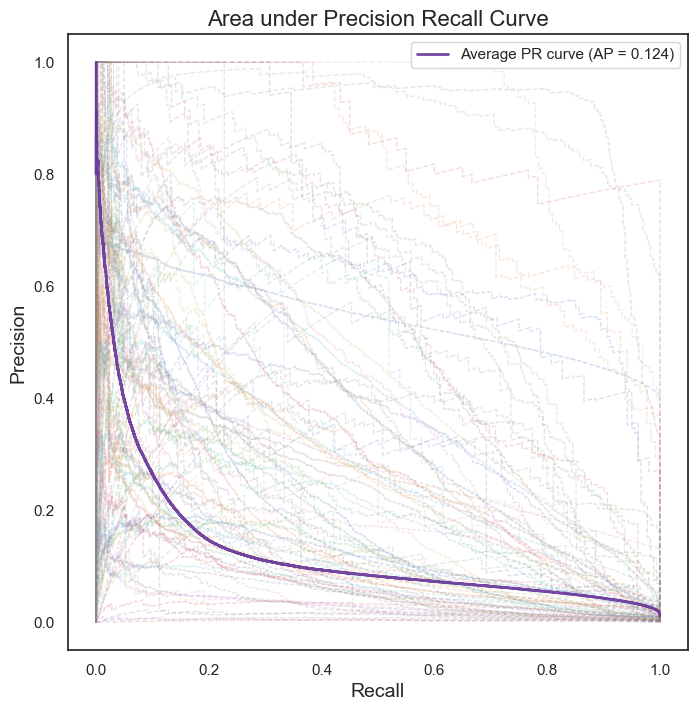

In [81]:
# Extract AUPRC & AP
def plot_AUPRC(y_true, y_score, title='Area Under Precision Recall Curve'):
    n_classes = len(set(y_true))  # 87 classes
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
    # y_pred_bin = label_binarize(y_pred, classes=np.arange(n_classes))

    # calculate precision, recall and average precision for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    sns.set_style('white')
    plt.figure(figsize=(8,8))

    for i in range(n_classes):
        precision[i], recall[i], _thresholds = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])
        plt.plot(recall[i], precision[i], lw=1, alpha=0.2, label=None, linestyle='dashed')

    # calculate micro-averaged AUPRC
    precision["micro"], recall["micro"], _thresholds = precision_recall_curve(y_true_bin.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_true_bin, y_score, average="micro")
    plt.plot(recall["micro"], precision["micro"], color="#663399", lw=2, alpha=0.9,
             label=f'Average PR curve (AP = {round(average_precision["micro"], 3)})'
             )

    plt.xlabel('Recall', fontsize=14)
    plt.ylabel('Precision', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend()
    plt.show()

plot_AUPRC(y_val, y_val_pred_prob)

In [50]:
target_names = ['class ' + str(x) for x in range(87)]
val_classification_report = classification_report(y_val, y_val_pred, target_names=target_names)
print("Validation Set - Classification Report:")
print(val_classification_report)

Validation Set - Classification Report:
              precision    recall  f1-score   support

     class 0       0.66      0.01      0.02     81526
     class 1       0.12      0.15      0.13      3368
     class 2       0.12      0.42      0.18      1057
     class 3       0.13      0.07      0.09      4623
     class 4       0.12      0.74      0.21       192
     class 5       0.17      0.82      0.28       337
     class 6       0.40      0.05      0.09     26818
     class 7       0.07      0.05      0.06      4163
     class 8       0.18      0.40      0.25       984
     class 9       0.12      0.68      0.20       862
    class 10       0.29      0.17      0.22      7105
    class 11       0.20      0.21      0.20      4467
    class 12       0.08      0.19      0.12      1868
    class 13       0.00      0.02      0.00       110
    class 14       0.21      0.67      0.33      1273
    class 15       0.17      0.49      0.26      1446
    class 16       0.05      0.09      0.

In [77]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
conf_matrix = conf_matrix/conf_matrix.sum(axis=1, keepdims=True) * 100 #Convert to percentage

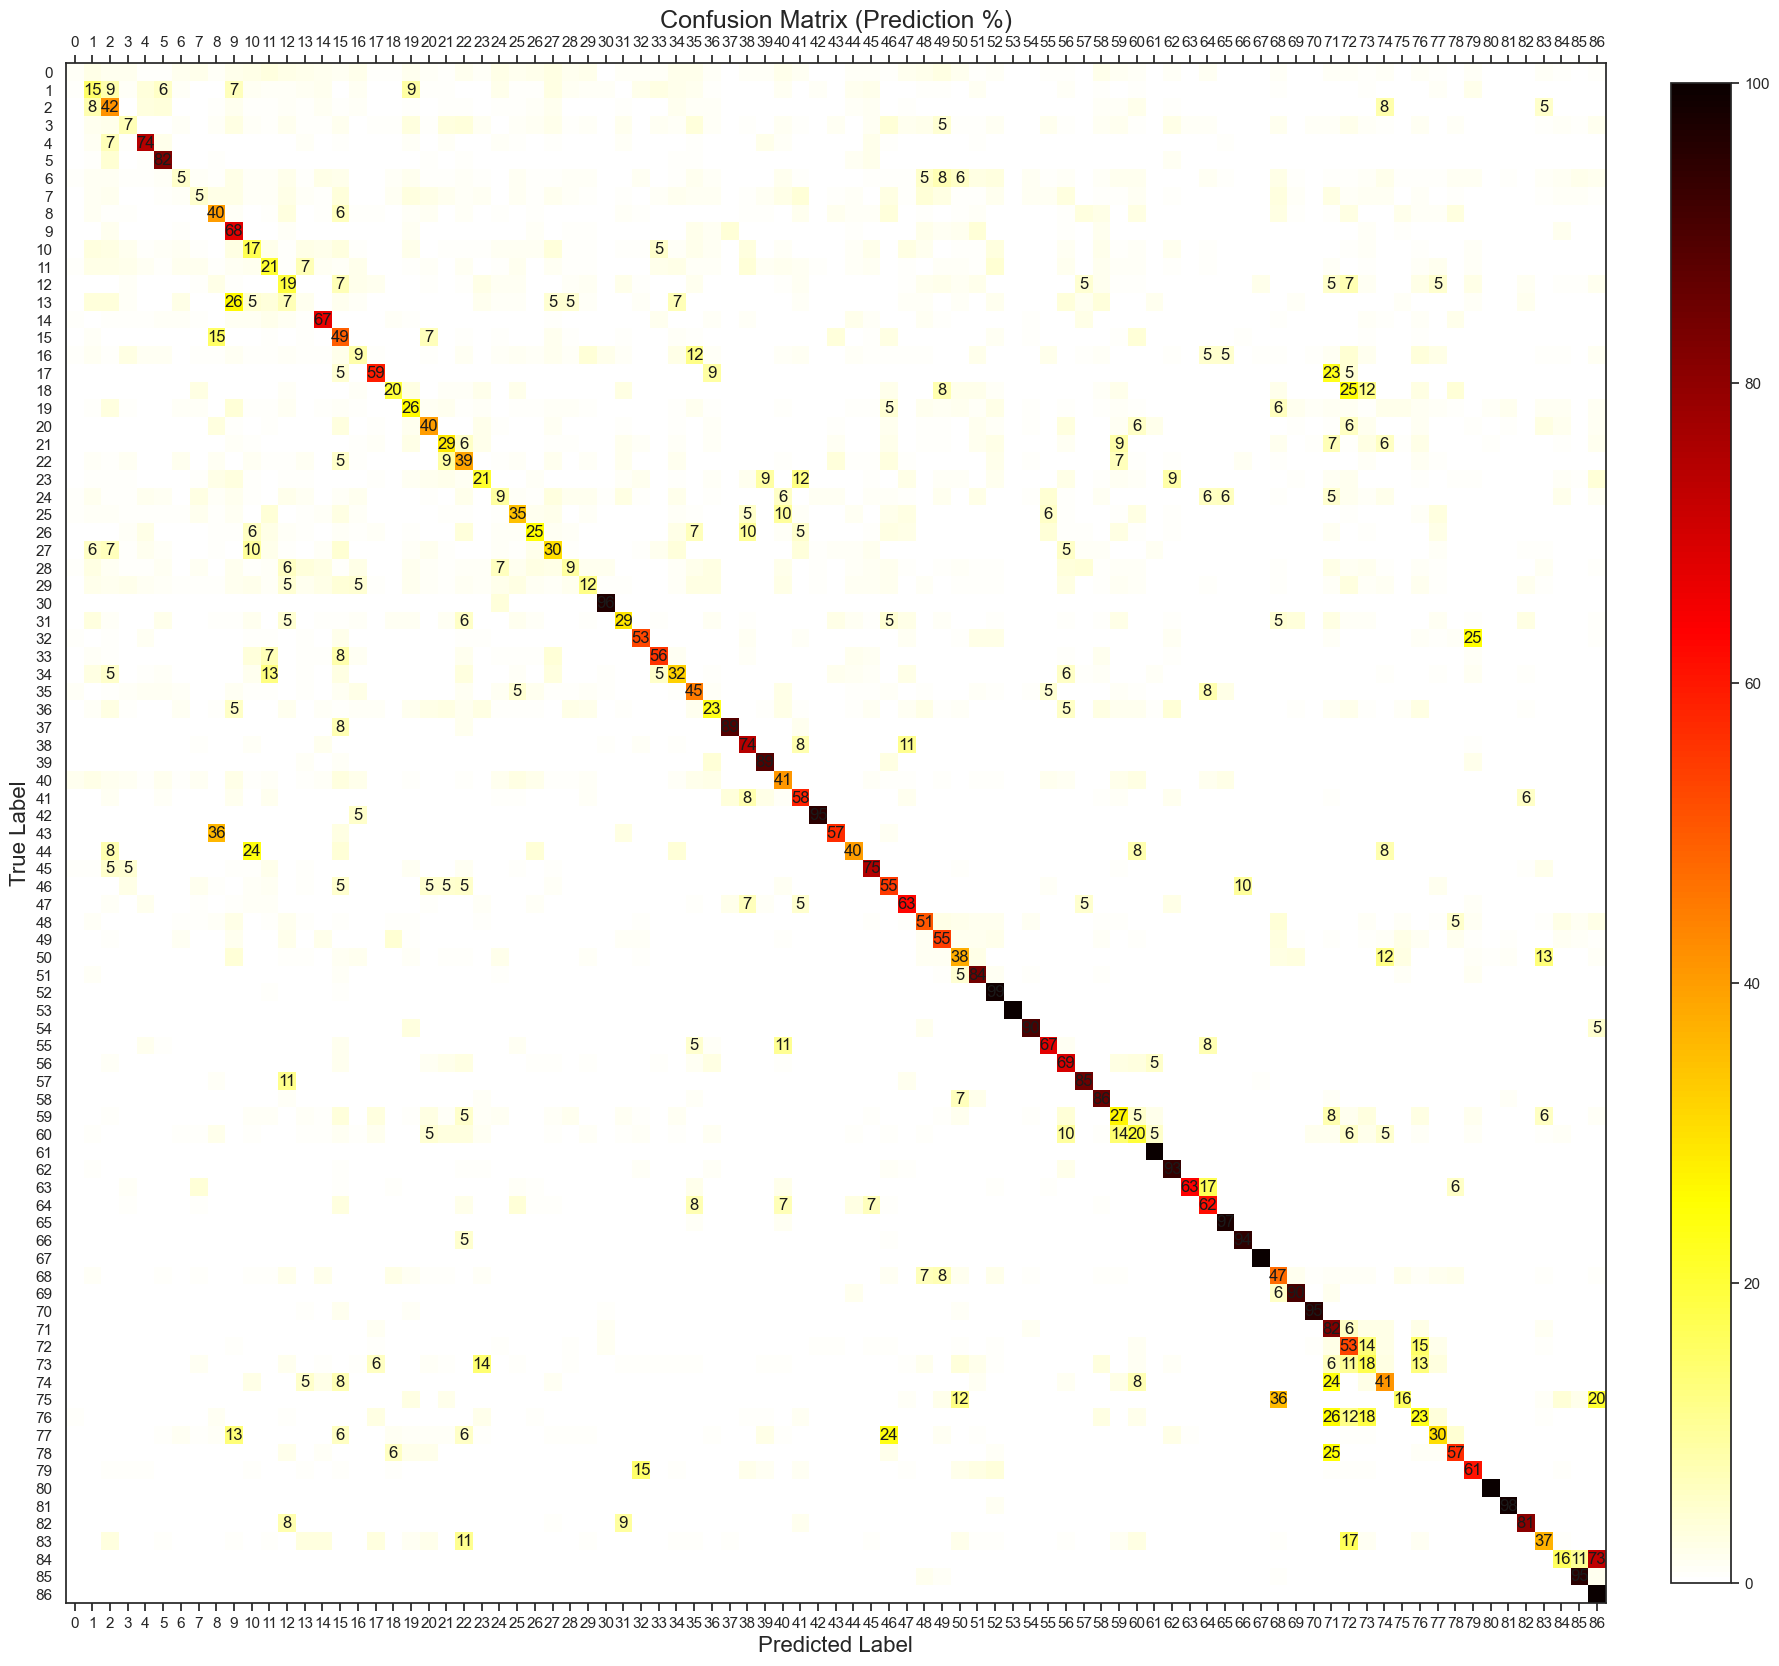

In [82]:
def plot_conf_matrix(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.matshow(conf_matrix, cmap='hot_r')
    plt.colorbar(im,cax = fig.add_axes([0.93, 0.12, 0.03, 0.75]))
    # sns.heatmap(
    #     conf_matrix, annot=True,
    #     cmap='hot_r',
    #     xticklabels=np.arange(87),
    #     yticklabels=np.arange(87))
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            if round(conf_matrix[i,j]) >= 5 and round(conf_matrix[i,j]) < 100:
                ax.text(j, i, round(conf_matrix[i,j]), va='center', ha='center', color='k')
    ax.set_xlabel("Predicted Label", fontsize=16)
    ax.set_ylabel("True Label", fontsize=16)
    ax.set_title("Confusion Matrix (Prediction %)", fontsize=18)
    ax.set_xticks(np.arange(87))
    ax.set_yticks(np.arange(87))
    ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
    plt.show()

plot_conf_matrix(conf_matrix)

In [53]:
# Training Logistic Regression with sklearn for severity rate
lr_high = LogisticRegression(penalty='l2', C=0.5, solver="sag", multi_class="ovr", max_iter=100, verbose=1, n_jobs=-1)  # Setting up the Regression
print("Training Logistic Regression for Severity Prediction...")
lr_high.fit(X_train, y_severity_train)                                      # Fitting the model to our training vectors
print("Training complete")

Training Logistic Regression for Severity Prediction...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 130 seconds
Training complete


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.2min finished


In [62]:
def model_evaluation_severity(y_true, y_pred, prefix="Training"):
    f2_macro =  metrics.fbeta_score(y_true, y_pred, average="binary", pos_label=1, beta=2)
    print(f"{prefix} F2-score: {round(f2_macro,4)}")

    mcc = metrics.matthews_corrcoef(y_true, y_pred)
    print(f"{prefix} Matthew Correlation Coefficient: {round(mcc,4)}")

    recall_macro = metrics.recall_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Recall: {round(recall_macro,4)}")

    precision_macro = metrics.precision_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} Precision: {round(precision_macro,4)}")

    f1_macro = metrics.f1_score(y_true, y_pred, average="binary", pos_label=1)
    print(f"{prefix} F1-score: {round(f1_macro,4)}")

    accuracy_macro = metrics.accuracy_score(y_true, y_pred)
    print(f"{prefix} Accuracy: {round(accuracy_macro,4)}")

In [63]:
# Predicting
print("Model Evaluation - Severity Prediction:")
y_high_train_pred = lr_high.predict(X_train)
y_high_val_pred = lr_high.predict(X_val)
y_high_test_pred = lr_high.predict(X_test)

# Evaluation - Macro F1 Score
model_evaluation_severity(y_severity_train, y_high_train_pred, prefix="Training")
print('')
model_evaluation_severity(y_severity_val, y_high_val_pred, prefix="Validation")
print('')
model_evaluation_severity(y_severity_test, y_high_test_pred, prefix="Testing")

Model Evaluation - Severity Prediction:
Training F2-score: 0.5924
Training Matthew Correlation Coefficient: 0.4727
Training Recall: 0.5656
Training Precision: 0.7306
Training F1-score: 0.6376
Training Accuracy: 0.7616

Validation F2-score: 0.2935
Validation Matthew Correlation Coefficient: 0.0743
Validation Recall: 0.2858
Validation Precision: 0.3291
Validation F1-score: 0.3059
Validation Accuracy: 0.6506

Testing F2-score: 0.2998
Testing Matthew Correlation Coefficient: 0.1021
Testing Recall: 0.2903
Testing Precision: 0.3448
Testing F1-score: 0.3152
Testing Accuracy: 0.6718


In [57]:
val_classification_report_high = classification_report(y_severity_val, y_high_val_pred, target_names=["Unknown Severity", "High Severity"])
print("Validation Set - Classification Report:")
print(val_classification_report_high)

Validation Set - Classification Report:
                  precision    recall  f1-score   support

Unknown Severity       0.75      0.79      0.77    147846
   High Severity       0.33      0.29      0.31     54527

        accuracy                           0.65    202373
       macro avg       0.54      0.54      0.54    202373
    weighted avg       0.64      0.65      0.64    202373



In [58]:
conf_matrix_high = confusion_matrix(y_severity_val, y_high_val_pred)
conf_matrix_high = conf_matrix_high/conf_matrix_high.sum(axis=1, keepdims=True) * 100
conf_matrix_high

array([[78.50871853, 21.49128147],
       [71.42149761, 28.57850239]])

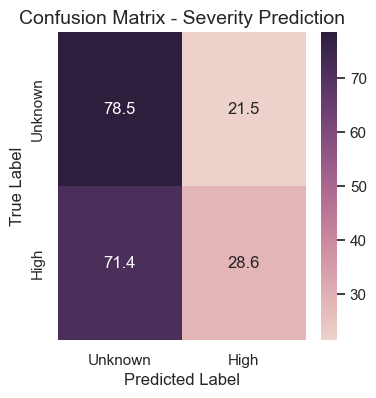

In [59]:
def plot_conf_matrix_high(conf_matrix):
    """Plot confusion matrix"""
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(
        conf_matrix, annot=True,
        cmap=sns.cubehelix_palette(as_cmap=True),
        xticklabels= ['Unknown', 'High'],
        yticklabels= ['Unknown', 'High'],
        fmt='.1f'
    )
    ax.set_xlabel("Predicted Label", fontsize=12)
    ax.set_ylabel("True Label", fontsize=12)
    ax.set_title("Confusion Matrix - Severity Prediction", fontsize=14)
    plt.show()

plot_conf_matrix_high(conf_matrix_high)